<a href="https://colab.research.google.com/github/aveen007/Av/blob/main/recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Clustering the text data into groups in order to recommend similar content within the same cluster

## 1.1 Installing and importing the packages

In [ ]:
!pip install stanza
!pip install unrar
!pip install fasttext
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.3/691.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=ea262d2d650403e14c6c8f8fb8e6126a328ea473555325ddd02c5e87668736e0
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.3-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fa

In [ ]:
import nltk
import pandas as pd
import numpy as np
import sys
import os
import stanza
import math
import fasttext
import re

from nltk import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize , PunktSentenceTokenizer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1.2 General understanding of the data set

In [ ]:
content_data = pd.read_csv("/content/drive/MyDrive/Copy of articles_being_share.csv")
user_data = pd.read_csv('/content/drive/MyDrive/Copy of user_interaction.csv')
print(content_data.shape)
print(user_data.shape)

(3122, 13)
(72312, 8)


In [ ]:
print (len(content_data['authorPersonId'].unique()))
print(content_data['contentType'].unique())
print(content_data['eventType'].unique())
print(content_data['lang'].unique())
print(content_data['authorCountry'].unique())
print(content_data['authorRegion'].unique())
print(len(content_data['authorUserAgent'].unique()))

252
['HTML' 'RICH' 'VIDEO']
['CONTENT REMOVED' 'CONTENT SHARED']
['en' 'pt' 'es' 'la' 'ja']
[nan 'BR' 'CA' 'US' 'AU' 'PT']
[nan 'MG' 'ON' 'SP' 'GA' 'NY' 'IL' 'NSW' 'RI' 'NJ' 'RJ' 'TX' 'AB' 'FL'
 '13' 'WA' '?' 'CA' 'SC' 'MS']
115


we can see that the content data can be categorized into groups easily because the number of unique values for each feature is much smaller than the actual size of the dataset.

In [ ]:
print (user_data['eventType'].unique())
print (len(user_data['personId'].unique()))
print (len(user_data['userCountry'].unique()))
print (len(user_data['userRegion'].unique()))
print (len(user_data['userAgent'].unique()))

['VIEW' 'FOLLOW' 'BOOKMARK' 'LIKE' 'COMMENT CREATED']
1895
24
72
1091


we can see that  the events are in 6 main types, which can help us in recommending the most suitable content for a specific user based on the type of the content they have already seen. Taken in consideration that some reaction types reflect more interest in the content e.g. a user who has liked an article is likely more interested in that article than an article he only viewed.

In [ ]:
print(content_data.info)


<bound method DataFrame.info of        timestamp        eventType            contentId       authorPersonId  \
0     1459192779  CONTENT REMOVED -6451309518266745024  4340306774493623681   
1     1459193988   CONTENT SHARED -4110354420726924665  4340306774493623681   
2     1459194146   CONTENT SHARED -7292285110016212249  4340306774493623681   
3     1459194474   CONTENT SHARED -6151852268067518688  3891637997717104548   
4     1459194497   CONTENT SHARED  2448026894306402386  4340306774493623681   
...          ...              ...                  ...                  ...   
3117  1487946604   CONTENT SHARED  9213260650272029784  3609194402293569455   
3118  1487947067   CONTENT SHARED -3295913657316686039  6960073744377754728   
3119  1488223224   CONTENT SHARED  3618271604906293310  1908339160857512799   
3120  1488300719   CONTENT SHARED  6607431762270322325 -1393866732742189886   
3121  1488307871   CONTENT SHARED  4109618890343020064  3891637997717104548   

          authorSes

In [ ]:
print(user_data.info)

<bound method DataFrame.info of         timestamp eventType            contentId             personId  \
0      1465413032      VIEW -3499919498720038879 -8845298781299428018   
1      1465412560      VIEW  8890720798209849691 -1032019229384696495   
2      1465416190      VIEW   310515487419366995 -1130272294246983140   
3      1465413895    FOLLOW   310515487419366995   344280948527967603   
4      1465412290      VIEW -7820640624231356730  -445337111692715325   
...           ...       ...                  ...                  ...   
72307  1485190425      LIKE -6590819806697898649 -9016528795238256703   
72308  1485190425      VIEW -5813211845057621660   102305705598210278   
72309  1485190072      VIEW -1999468346928419252 -9196668942822132778   
72310  1485190434      VIEW -6590819806697898649 -9016528795238256703   
72311  1485187988      VIEW  5669290109546991426  5713241217519616260   

                 sessionId                                          userAgent  \
0      126

## 1.3 Building the vector space model

we attempt to measure the similarity between each two texts of the content data by using tfidf vectorizer to get the tfidf score for the words in each of the texts and then use cosine similarity to measure the similarity between each two texts based on the resulting tfidf matrix.

In [ ]:
tfidf=TfidfVectorizer(stop_words='english')

In [ ]:
content_data['text']=content_data['text'].fillna("")

we encode the non string features into numeric categories, for the clustering step

In [ ]:
from sklearn.preprocessing import LabelEncoder
le_eventType=LabelEncoder()
le_authorUserAgent=LabelEncoder()
le_authorRegion=LabelEncoder()
le_authorCountry=LabelEncoder()
le_contentType=LabelEncoder()
le_lang=LabelEncoder()



content_data['eventType']=le_eventType.fit_transform(content_data['eventType'])
content_data['authorUserAgent']=le_authorUserAgent.fit_transform(content_data['authorUserAgent'])
content_data['authorRegion']=le_authorRegion.fit_transform(content_data['authorRegion'])
content_data['authorCountry']=le_authorCountry.fit_transform(content_data['authorCountry'])
content_data['contentType']=le_contentType.fit_transform(content_data['contentType'])
content_data['lang']=le_lang.fit_transform(content_data['lang'])


In [ ]:
content_data.info()
content_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        3122 non-null   int64 
 1   eventType        3122 non-null   int64 
 2   contentId        3122 non-null   int64 
 3   authorPersonId   3122 non-null   int64 
 4   authorSessionId  3122 non-null   int64 
 5   authorUserAgent  3122 non-null   int64 
 6   authorRegion     3122 non-null   int64 
 7   authorCountry    3122 non-null   int64 
 8   contentType      3122 non-null   int64 
 9   url              3122 non-null   object
 10  title            3122 non-null   object
 11  text             3122 non-null   object
 12  lang             3122 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 317.2+ KB


,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,0,-6451309518266745024,4340306774493623681,8940341205206233829,114,19,5,0,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,0
1,1459193988,1,-4110354420726924665,4340306774493623681,8940341205206233829,114,19,5,0,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,0
2,1459194146,1,-7292285110016212249,4340306774493623681,8940341205206233829,114,19,5,0,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,0
3,1459194474,1,-6151852268067518688,3891637997717104548,-1457532940883382585,114,19,5,0,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,0
4,1459194497,1,2448026894306402386,4340306774493623681,8940341205206233829,114,19,5,0,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,0


In [ ]:
tfidf_matrix=tfidf.fit_transform(content_data['text'])

In [ ]:
tfidf_matrix

<3122x72353 sparse matrix of type '<class 'numpy.float64'>'
	with 891728 stored elements in Compressed Sparse Row format>

## 1.4 Develop the cosine similarity

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
cosine_similarity=linear_kernel(tfidf_matrix,tfidf_matrix)

In [ ]:
indices=pd.Series(content_data.index,index=content_data['title']).drop_duplicates()

In [ ]:
indices

title
Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's                                         0
Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's                                         1
Bitcoin Future: When GBPcoin of Branson Wins Over USDcoin of Trump                                              2
Google Data Center 360° Tour                                                                                    3
IBM Wants to "Evolve the Internet" With Blockchain Technology                                                   4
                                                                                                             ... 
Conheça a Liga IoT, plataforma de inovação aberta que irá acelerar projetos ligados a Internet das Coisas    3117
Amazon takes on Skype and GoToMeeting with its Chime video conferencing app                                  3118
Code.org 2016 Annual Report                                                       

In [ ]:
cosine_similarity.shape

(3122, 3122)

## 1.5 Building a simple recommender (without clustering)

we  can build a simplified version of our recommender for a specific title based on the cosine similarity alone.
We recommened the 10 most similar articles to the given title.

In [ ]:
def get_recommendation(title,cos_sim=cosine_similarity):
  index=indices[title][0]
  sim_scores=enumerate(cos_sim[index])
  sim_scores=sorted(sim_scores,key=lambda x:x[1],reverse=True)
  sim_scores=sim_scores[1:11]
  sim_idx=[i[0] for i in sim_scores]
  print(content_data['title'].iloc[sim_idx])
get_recommendation("Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's")


1       Ethereum, a Virtual Currency, Enables Transact...
9       The Rise And Growth of Ethereum Gets Mainstrea...
525     For Blockchain VCs, the Time for Ethereum Inve...
184     Ethereum and Bitcoin Are Market Leaders But No...
83      Microsoft Adds Ethereum to Windows Platform Fo...
112     Solidity Available in Visual Studio - Ethereum...
187     Microsoft Continues to Embrace Ethereum & Bitc...
115     Cashila Announces Convenient Buy and Sell Feat...
131     Eyeing Volume, Asian Exchanges Add Support for...
2378    Are you a bitcoin denialist? - Chris Skinner's...
Name: title, dtype: object


## 1.6 Clustering with Kmeans

We build a more complex recommender using Kmeans clustering to group similar contents in the same cluster so we can later on recommend similar content based on the clusters.

In [ ]:
data=content_data
data=data.drop(columns=['title','text','url','contentId'])

for i in range(cosine_similarity.shape[0]):
  name='t'+str(i)
  data[name]=cosine_similarity[i]

<ipython-input-35-88001c152281>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[name]=cosine_similarity[i]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### best k, elbow method

optimizing the number of clusters using k best elbow method from kneed library.

In [ ]:
from sklearn.cluster import KMeans
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)


from kneed import KneeLocator
k_best = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

k_best.elbow

4

the best k for our dataset is 4.

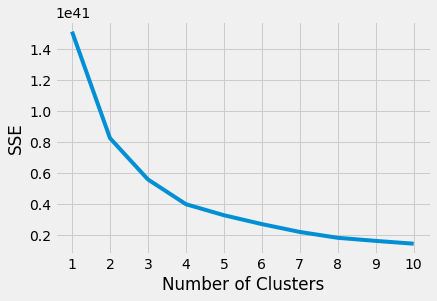

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:


# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=k_best.elbow, **kmeans_kwargs)
# fit the model
y = kmeans.fit_predict(data)

content_data['Cluster'] = y
data['Cluster'] = y

In [ ]:
content_data.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,Cluster
0,1459192779,0,-6451309518266745024,4340306774493623681,8940341205206233829,114,19,5,0,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,0,3
1,1459193988,1,-4110354420726924665,4340306774493623681,8940341205206233829,114,19,5,0,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,0,3
2,1459194146,1,-7292285110016212249,4340306774493623681,8940341205206233829,114,19,5,0,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,0,3
3,1459194474,1,-6151852268067518688,3891637997717104548,-1457532940883382585,114,19,5,0,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,0,1
4,1459194497,1,2448026894306402386,4340306774493623681,8940341205206233829,114,19,5,0,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,0,3


In [ ]:
content_data['Cluster'].unique()

array([3, 1, 2, 0], dtype=int32)

# 2. Getting recommendations for users

now for the user interactions dataset.

## 2.1 processing user data

In [ ]:
user_data.shape

(72312, 8)

Giving weights for each event type in the user interactions according to how much the user was interested in the content

In [ ]:
weights={'VIEW':1, 'FOLLOW':4, 'BOOKMARK':5, 'LIKE':2, 'COMMENT CREATED':3}

In [ ]:
weights

{'VIEW': 1, 'FOLLOW': 4, 'BOOKMARK': 5, 'LIKE': 2, 'COMMENT CREATED': 3}

we want to define a function that takes a user and prints out 10 recommendations for them based on the content they've already seen
we define the following functions:

- get the content IDs  for a specific user

In [ ]:
def get_user_content(user_id):
  content=user_data.loc[user_data['personId']==user_id]
  return content[['contentId','eventType']]
content=get_user_content(344280948527967603)
content2=get_user_content(102305705598210278)

content

,contentId,eventType
3,310515487419366995,FOLLOW
8,310515487419366995,VIEW
37,310515487419366995,BOOKMARK
40,310515487419366995,LIKE
52,310515487419366995,VIEW
784,3569727790804487273,VIEW
10752,310515487419366995,VIEW
14754,-5784991738549272379,VIEW
14817,-5784991738549272379,VIEW
24599,310515487419366995,VIEW


- calculate cluster score (how much of the user interactions belong to each of the clusters based on the weights -- how much the user was interested in the cluster content)

In [ ]:
def score_cluster(content):
  scores=[]
  total=0
  for i in content_data['Cluster'].unique():
    scores.append(0)
  for i,c in content.iterrows():
    index=content_data.loc[content_data['contentId']==c['contentId']]
    index=index['Cluster']

    scores[int(index)]+=weights[c['eventType']]
    total+=weights[c['eventType']]
  scores=[  int(s*10/total) for s in scores]
  return scores
score1=score_cluster(content)
score1

[0, 1, 4, 4]

In [ ]:
score2=score_cluster(content2)
score2

[3, 1, 2, 2]

from the 2 previous examples we can see how each number represents how many articles we should recommend from each cluster based on how much the user engaged previously from content that is similar to the content of that cluster.
e.g. the first user didn't engage with any content similar to cluster 1 so 0 articles will be recommended from it , while the second user will be recommended 3 from it.

- recommend a specified number of article from each cluster based on the previous calculations of interest and similarity.

- paying attention that the content which the user has already seen is not re-recommended

In [ ]:
def get_recommendation_with_clustering(scores, ids):
  all_recommended_articles=[]
  similar_articles=np.zeros(len(cosine_similarity[0]))
  for i,id in ids.iterrows():
    all=content_data.loc[content_data['contentId']==id['contentId']]

    title=all['title']
    cluster=all['Cluster']
    # print(title)
    index=indices[title][0]
    sim_scores=cosine_similarity[index]
    similar_articles=np. add(similar_articles,sim_scores)

  sim_scores=sorted(enumerate(similar_articles),key=lambda x:x[1],reverse=True)


  for i  in range(len(scores)):
    j=scores[i]
    for article in sim_scores:
      if (j==0): break
      cluster=content_data.iloc[article[0]]['Cluster']
      con_id=content_data['contentId'].iloc[article[0]]

      if (cluster==i and ids['contentId'].tolist().count(con_id)==0):
        all_recommended_articles.append(content_data['title'].iloc[article[0]])
        j=j-1
  return all_recommended_articles

recommendations=get_recommendation_with_clustering(score1,content)
recommendations2=get_recommendation_with_clustering(score2,content2)
for recommendation in recommendations:

  print(recommendation)




Dicas para aumentar produtividade: 14 dicas incríveis.
71 erros de vocabulário e pronúncia em inglês que você faz
Confira as novidades apresentadas no Google I/O 2016
A saga do jovem CEO da Dasa
diagramas para entender, criar, inovar e empreender: 3
SINAIS do FUTURO imediato: #1, internet das coisas
Startups matam. E suas vítimas são as empresas que ainda não entendem o que é a Economia do Acesso
Por dentro do Nubank, conheça os segredos da fintech mais festejada do país
Cinco competências comportamentais para você ser um bom líder


In [ ]:
for recommendation in recommendations2:

  print(recommendation)

Machine Learning for Designers
Being A Developer After 40 - Free Code Camp
Machine Learning as a Service: How Data Science Is Hitting the Masses
Stream processing, Event sourcing, Reactive, CEP... and making sense of it all - Confluent
How Google is Remaking Itself as a "Machine Learning First" Company - Backchannel
How Google is Remaking Itself as a "Machine Learning First" Company - Backchannel
Stream processing, Event sourcing, Reactive, CEP... and making sense of it all
What 2 Years of Android Development Have Taught Me the Hard Way - Thought's by Aritra Roy
